<a href="https://colab.research.google.com/github/abuhurera8320/Hate_Speech_Detection/blob/main/Roman_Urdu_Hate_Speech_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential,load_model
from keras.layers import Conv1D,LSTM,Dense,Embedding,RepeatVector,TimeDistributed,Bidirectional,GRU,SimpleRNN
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import corpus_bleu
from IPython.display import Markdown, display
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import text_to_word_sequence

In [15]:
df=pd.read_csv('/content/drive/MyDrive/FYP /task_1_train.tsv', sep='\t')

In [16]:
df.columns=['Text','Label']
df.count()

Text     7208
Label    7208
dtype: int64

In [17]:
l=df['Label'].unique()
l_dict={0:'Abusive/Offensive',1:'Normal'}
for i in l:
    print('Label {} is for {}'.format(i,l_dict[i]))

Label 0 is for Abusive/Offensive
Label 1 is for Normal


In [18]:
offensivedf=df.loc[df['Label']==1]
offensivedf.count()

Text     3850
Label    3850
dtype: int64

In [19]:
df1=pd.read_csv('/content/drive/MyDrive/FYP /task_1_test.tsv', sep='\t')

In [20]:
df1.columns=['Text','Label']
df1.count()

Text     2002
Label    2002
dtype: int64

In [21]:
offensivedf=df1.loc[df1['Label']==1]
offensivedf.count()

Text     1069
Label    1069
dtype: int64

In [22]:
Neutral=df.loc[df['Label']==1]
Neutral.head()

,Text,Label
6,hum kisi se km nhi,1
7,aurat bhatak sakri hy kbi “maa” ni bhatakti . ...,1
10,with due respect sir kya aurat march se ye ch...,1
15,😂😂😂😂😂😂 chal ja tujhy maaf kia,1
16,agr ap chahtay hn k log ap ko acha kahean to a...,1


In [23]:
hate=df.loc[df['Label']==0]
hate.head()

,Text,Label
0,bhaunk bhaunk ke pagal ho jaata ab tak....,0
1,shivsaina nam mulla saina rakh hijra uddh...,0
2,there are some yahodi daboo like imran chore z...,0
3,"chutiye ye hunduism ni he islam he , isme koi ...",0
4,han g rakhail e awal kiya bak rai hai. kisay a...,0


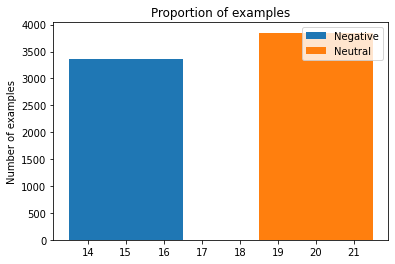

In [24]:
Neu = df[df['Label'] == 1].shape[0]
Neg = df[df['Label'] == 0].shape[0]
# bar plot of the 3 classes
plt.bar(15,Neg,3, label="Negative")
plt.bar(20,Neu,3, label="Neutral")
plt.legend()
plt.ylabel('Number of examples')
plt.title('Proportion of examples')
plt.show()

In [26]:
df = pd.concat([df, df1], ignore_index=True, sort=False)

In [27]:
df.shape

(9210, 2)

## Data Preprocessing
#### 1. Removing Punctuations
#### 2. Converting to Lower case
#### 3. Removing stopwords

In [28]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [29]:
import re
def remove_punct(text):
    ''' Input parameter:
    text: (str)
    this method is used to take each text line and check the characters if it
    contains any puntuation and then remove them with blank space'''  
    text  = "".join([char for [char] in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text


In [30]:
# removing all the punctuation
df['Text'] = df['Text'].apply(lambda x: remove_punct(str(x))) 

In [31]:
df['Text'].head()

0               bhaunk bhaunk ke pagal ho jaata ab tak
1    shivsaina  nam mulla  saina  rakh  hijra  uddh...
2    there are some yahodi daboo like imran chore z...
3    chutiye ye hunduism ni he islam he  isme koi k...
4    han g rakhail e awal kiya bak rai hai kisay ah...
Name: Text, dtype: object

#### Converting the text corpus to Lower Case

In [32]:
def convert_to_lower_case(text):
    ''' Input parameter:
    text: (str)
    this method is used to take each text line and converts the characters  into lower case and joins them further'''
    text  = "".join([char.lower() for [char] in text if char not in string.punctuation])
    return text


In [33]:
df['Text'] = df['Text'].apply(lambda x: convert_to_lower_case(str(x))) #calling lower case on each line

In [34]:
df['Text'].head()

0               bhaunk bhaunk ke pagal ho jaata ab tak
1    shivsaina  nam mulla  saina  rakh  hijra  uddh...
2    there are some yahodi daboo like imran chore z...
3    chutiye ye hunduism ni he islam he  isme koi k...
4    han g rakhail e awal kiya bak rai hai kisay ah...
Name: Text, dtype: object

### Removing Stopwords

In [35]:
stopwords=['ai', 'ayi', 'hy', 'hai', 'main', 'ki', 'tha', 'koi', 'ko', 'sy', 'woh', 'bhi', 'aur', 'wo', 'yeh', 'rha', 
           'hota', 'ho', 'ga', 'ka', 'le', 'lye', 'kr', 'kar', 'lye', 'liye', 'hotay', 'waisay', 'gya', 'gaya', 'kch',
           'ab', 'thy', 'thay', 'houn', 'hain', 'han', 'to','is', 'hi', 'jo', 'kya', 'thi', 'se', 'pe', 'phr', 'wala',
           'waisay', 'us', 'na', 'ny', 'hun', 'rha', 'raha', 'ja', 'rahay', 'abi', 'uski', 'ne', 'haan', 'acha', 'nai',
           'sent', 'you', 'kafi', 'gai', 'rhy', 'kuch', 'jata', 'aye', 'ya', 'dono', 'hoa', 'aese', 'de', 'wohi',
           'jati', 'jb', 'krta', 'lg', 'rahi', 'hui', 'karna', 'krna', 'gi', 'hova', 'yehi', 'jana', 'jye', 'chal', 'mil',
           'tu', 'hum', 'par', 'hay', 'kis', 'sb', 'gy', 'dain', 'krny', 'tou','h','je','or','jee','he','in','un','kay','ki','ya','ap','meri','me']


In [36]:
dictStopWords = {} # global variable
forFastTextData = []
def removeStopWordss(text):
    text = re.sub('[^a-zA-Z]',' ',str(text))
    text = text.lower()
    wordList =str(text).split()
    for word in wordList:
        if word in stopwords:
            wordList.remove(word)
            if word not in dictStopWords:
                dictStopWords[word]= 1
            else:
                dictStopWords[word] = dictStopWords[word] + 1
    newSentence = " ".join(wordList)
    forFastTextData.append(newSentence.split())
    return (newSentence)

In [37]:
df['Text'] = df['Text'].apply(lambda x: removeStopWordss(x)) # sentence with removed stop words

In [38]:
## checking for most common stopwords from the dictionary
import collections
from collections import Counter
dictGraph = {}
d = Counter(dictStopWords) # creating a counter 
d.most_common(10) 
for k,v in d.most_common(10):
    dictGraph[k] = v
dictGraph

{'hai': 2457,
 'hain': 781,
 'ho': 1154,
 'ka': 1490,
 'ki': 2205,
 'ko': 1808,
 'me': 722,
 'na': 708,
 'se': 1123,
 'to': 1369}

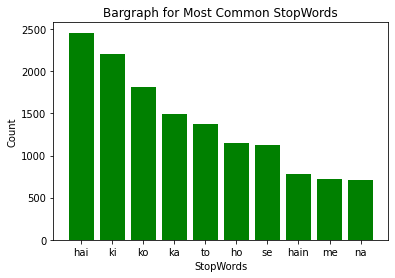

In [39]:
#plotting a graph of 10 most common stopwords from dictionary
plt.bar(dictGraph.keys(), dictGraph.values(), align='center', color = 'green')
plt.title('Bargraph for Most Common StopWords')
plt.xlabel('StopWords')
plt.ylabel('Count')
plt.show()

In [40]:
sum(dictGraph.values())

13817

In [42]:
df.to_csv('/content/drive/MyDrive/FYP /preprocessed_df.csv')

### Removal of Characters(Stemming)

In [ ]:
def replacing_characters(word):
    ''' Input Parameter: 
    word: word from the sentences'''
 
    word = re.sub(r'ain$', r'ein', word)
    word = re.sub(r'ai', r'ae', word)
    word = re.sub(r'ay$', r'e', word)
    word = re.sub(r'ey$', r'e', word)
    word = re.sub(r'aa+', r'aa', word)
    word = re.sub(r'e+', r'ee', word)
    word = re.sub(r'ai', r'ahi', word) # e.g "sahi and sai nahi"
    word = re.sub(r'ai', r'ahi', word)
    word = re.sub(r'ie$', r'y', word)
    word = re.sub(r'^es', r'is', word)
    word = re.sub(r'a+', r'a', word)
    word = re.sub(r'j+', r'j', word)
    word = re.sub(r'd+', r'd', word)
    word = re.sub(r'u', r'o', word)
    word = re.sub(r'o+', r'o', word)
    if not re.match(r'ar', word):
        word = re.sub(r'ar', r'r', word)
        word = re.sub(r'iy+', r'i', word)
        word = re.sub(r'ih+', r'eh', word)
        word = re.sub(r's+', r's', word)
    if re.search(r'[rst]y', 'word') and word[-1] != 'y':
        word = re.sub(r'y', r'i', word)
    if re.search(r'[^a]i', word):
        word = re.sub(r'i$', r'y', word)
    if re.search(r'[a-z]h', word):
        word = re.sub(r'h', '', word)
    return word

In [ ]:
df['Text'] = df['Text'].apply(lambda x: replacing_characters(x))

In [43]:
df=pd.read_csv('/content/drive/MyDrive/FYP /preprocessed_df.csv')
df.shape

(9210, 3)

In [44]:
df['Text'].head()

0                     bhaunk bhaunk ke pagal jaata tak
1    shivsaina nam mulla saina rakh hijra uddhav th...
2    there are some yahodi daboo like imran chore z...
3    chutiye ye hunduism ni islam isme kisi muslim ...
4    g rakhail e awal kiya bak rai kisay ahmaq kah ...
Name: Text, dtype: object

**Tokenization and Test Train Split**

In [45]:
from sklearn.model_selection import train_test_split

In [46]:
X=df['Text']
y=df['Label']
X.shape

(9210,)

In [47]:
count = df['Text'].str.split().apply(len)
count=count.sort_values(axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last', ignore_index=False, key=None)
MAX_SEQUENCE_LENGTH=count.iloc[0]+10
MAX_SEQUENCE_LENGTH

66

In [48]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 21796


In [49]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

In [50]:

X_train = pad_sequences((tokenizer.texts_to_sequences(X_train)),
                        maxlen = MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test),
                      maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",X_train.shape)
print("Testing X Shape:",X_test.shape)

Training X Shape: (7368, 66)
Testing X Shape: (1842, 66)


In [51]:
print(f'train data:{X_train.shape}, train labels:{y_train.shape},test data:{X_test.shape}, test labels:{y_test.shape}')

train data:(7368, 66), train labels:(7368,),test data:(1842, 66), test labels:(1842,)


## Importing Pretrained Word2vec embeddings

In [52]:
# load embeding for text file
embeddings_index1 = dict()
f = open('/content/drive/MyDrive/FYP /vectors500000.txt')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index1[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index1))

Loaded 31308 word vectors.


In [53]:
# load embeding for text file
embeddings_index2 = dict()
f = open('/content/drive/MyDrive/FYP /word2vec_RU.txt')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index2[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index2))

Loaded 8750 word vectors.


In [54]:
count=0
wordcount1=0
wordcount2=0
dims=100
flag=1
#word_index = {w: i for i, w in enumerate(embeddings_index, 1)}
embedding_matrix = np.zeros((len(word_index)+1, dims))
for word, i in word_index.items():
  if word in embeddings_index1.keys():
    embedding_vector = embeddings_index1.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector[:dims]
        wordcount1 +=1
        
  elif word in embeddings_index2.keys():
        embedding_vector = embeddings_index2.get(word)
        if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
         embedding_matrix[i] = embedding_vector[:dims]
         wordcount2 +=1
        
  else:
     count +=1
     
      

In [55]:
print('Embedding Stats :')
print(f'Words found in first embedding: {wordcount1}')
print(f'Words found in second embedding: {wordcount2}')
print(f'Words not found in any embedding: {count}')
print(f'Total words found in both embeddings: {wordcount1+wordcount2}')

Embedding Stats :
Words found in first embedding: 9810
Words found in second embedding: 2216
Words not found in any embedding: 9769
Total words found in both embeddings: 12026


In [56]:
embedding_matrix.shape

(21796, 100)

In [57]:
#sequences= X.apply(lambda x:text_to_word_sequence(x))

##**Simple RNN's**

In [86]:
#%%time
#with strategy.scope():
    # A simpleRNN without any pretrained embeddings and one dense layer
model = Sequential()
model.add(Embedding(embedding_matrix.shape[0],embedding_matrix.shape[1],weights=[embedding_matrix],input_length=MAX_SEQUENCE_LENGTH,trainable=False))
model.add(Dropout(0.2))
model.add(SimpleRNN(20))
model.add(Dropout(0.2))
model.add(Dense(200,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 66, 100)           2179600   
                                                                 
 dropout_4 (Dropout)         (None, 66, 100)           0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 20)                2420      
                                                                 
 dropout_5 (Dropout)         (None, 20)                0         
                                                                 
 dense_9 (Dense)             (None, 200)               4200      
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 1)                

In [87]:
history=model.fit(X_train, y_train, epochs=5, batch_size=128,validation_data=(X_test, y_test),verbose=1)

Epoch 1/5
58/58 [==============================] - 4s 60ms/step - loss: 0.6887 - accuracy: 0.5402 - val_loss: 0.6735 - val_accuracy: 0.5679
Epoch 2/5
58/58 [==============================] - 5s 87ms/step - loss: 0.6786 - accuracy: 0.5681 - val_loss: 0.6708 - val_accuracy: 0.5896
Epoch 3/5
58/58 [==============================] - 3s 57ms/step - loss: 0.6766 - accuracy: 0.5755 - val_loss: 0.6669 - val_accuracy: 0.5820
Epoch 4/5
58/58 [==============================] - 3s 57ms/step - loss: 0.6724 - accuracy: 0.5749 - val_loss: 0.6667 - val_accuracy: 0.5771
Epoch 5/5
58/58 [==============================] - 3s 58ms/step - loss: 0.6694 - accuracy: 0.5778 - val_loss: 0.6624 - val_accuracy: 0.5988


In [88]:
model.layers[0].trainable=True

In [89]:

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 66, 100)           2179600   
                                                                 
 dropout_4 (Dropout)         (None, 66, 100)           0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 20)                2420      
                                                                 
 dropout_5 (Dropout)         (None, 20)                0         
                                                                 
 dense_9 (Dense)             (None, 200)               4200      
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 1)                

In [90]:
history=model.fit(X_train, y_train, epochs=10, batch_size=128,validation_data=(X_test, y_test),verbose=1)

Epoch 1/10
58/58 [==============================] - 4s 62ms/step - loss: 0.6636 - accuracy: 0.5920 - val_loss: 0.6598 - val_accuracy: 0.6015
Epoch 2/10
58/58 [==============================] - 3s 58ms/step - loss: 0.6663 - accuracy: 0.5874 - val_loss: 0.6565 - val_accuracy: 0.5988
Epoch 3/10
58/58 [==============================] - 3s 58ms/step - loss: 0.6588 - accuracy: 0.5999 - val_loss: 0.6542 - val_accuracy: 0.6156
Epoch 4/10
58/58 [==============================] - 3s 59ms/step - loss: 0.6577 - accuracy: 0.6044 - val_loss: 0.6547 - val_accuracy: 0.6048
Epoch 5/10
58/58 [==============================] - 3s 57ms/step - loss: 0.6598 - accuracy: 0.5908 - val_loss: 0.6532 - val_accuracy: 0.6113
Epoch 6/10
58/58 [==============================] - 5s 80ms/step - loss: 0.6559 - accuracy: 0.6044 - val_loss: 0.6531 - val_accuracy: 0.6097
Epoch 7/10
58/58 [==============================] - 4s 63ms/step - loss: 0.6581 - accuracy: 0.6012 - val_loss: 0.6525 - val_accuracy: 0.5988
Epoch 8/10
58

In [91]:
def decode_sentiment(score):
    return 1 if score>0.5 else 0

In [92]:
from sklearn import metrics
scores = model.predict(X_test)
#print(y_pred.shape)
#y_pred = np.argmax(y_pred, axis=1)
#print(y_pred.shape)

#
y_pred = [decode_sentiment(score) for score in scores]
metrics.accuracy_score(y_test, y_pred)

0.6080347448425625

In [93]:
print("classification report:")
print(metrics.classification_report(y_test, y_pred))#, target_names=target_names))

classification report:
              precision    recall  f1-score   support

           0       0.61      0.47      0.53       868
           1       0.61      0.73      0.66       974

    accuracy                           0.61      1842
   macro avg       0.61      0.60      0.60      1842
weighted avg       0.61      0.61      0.60      1842



In [94]:
print("confusion matrix: ")
print(metrics.confusion_matrix(y_test, y_pred))

confusion matrix: 
[[410 458]
 [264 710]]


Text(0.5, 1.0, 'Loss evolution')

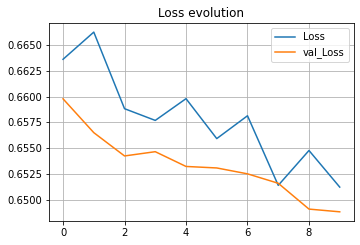

In [95]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')


Text(0.5, 1.0, 'Accuracy evolution')

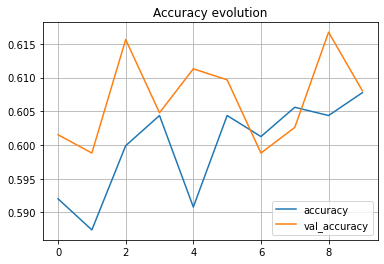

In [96]:
plt.subplot(1, 1, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy evolution')

## **Bi-Directional LSTM**

In [77]:

model = Sequential()

# Keras Embedding layer with Word2Vec weights initialization
model.add(Embedding(embedding_matrix.shape[0],embedding_matrix.shape[1],weights=[embedding_matrix],input_length=MAX_SEQUENCE_LENGTH,trainable=False))

#model.add(Dropout(0.25))
#model.add(Conv1D(128, 3, activation='relu'))
model.add(Bidirectional(LSTM(200, dropout=0.3)))
model.add(Dense(512,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])
#ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1, min_lr = 0.01, monitor = 'val_loss',verbose = 1)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 66, 100)           2179600   
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              160800    
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 512)               102912    
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 dense_8 (Dense)             (None, 1)                 257       
                                                                 
Total params: 2,574,897
Trainable params: 395,297
Non-trainable params: 2,179,600
______________________________________

In [78]:
history = model.fit(X_train, y_train, epochs=10, batch_size=128,
                    validation_data=(X_test, y_test), verbose=1)

Epoch 1/10
58/58 [==============================] - 5s 32ms/step - loss: 0.6819 - accuracy: 0.5582 - val_loss: 0.6501 - val_accuracy: 0.6086
Epoch 2/10
58/58 [==============================] - 1s 14ms/step - loss: 0.6538 - accuracy: 0.6102 - val_loss: 0.6265 - val_accuracy: 0.6433
Epoch 3/10
58/58 [==============================] - 1s 13ms/step - loss: 0.6358 - accuracy: 0.6330 - val_loss: 0.6212 - val_accuracy: 0.6379
Epoch 4/10
58/58 [==============================] - 1s 14ms/step - loss: 0.6225 - accuracy: 0.6493 - val_loss: 0.6161 - val_accuracy: 0.6493
Epoch 5/10
58/58 [==============================] - 1s 14ms/step - loss: 0.6081 - accuracy: 0.6665 - val_loss: 0.6055 - val_accuracy: 0.6661
Epoch 6/10
58/58 [==============================] - 1s 14ms/step - loss: 0.6015 - accuracy: 0.6683 - val_loss: 0.6158 - val_accuracy: 0.6504
Epoch 7/10
58/58 [==============================] - 1s 14ms/step - loss: 0.5879 - accuracy: 0.6796 - val_loss: 0.5599 - val_accuracy: 0.7302
Epoch 8/10
58

In [79]:
model.layers[0].trainable=True
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 66, 100)           2179600   
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              160800    
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 512)               102912    
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 dense_8 (Dense)             (None, 1)                 257       
                                                                 
Total params: 2,574,897
Trainable params: 2,574,897
Non-trainable params: 0
____________________________________________

In [80]:
history = model.fit(X_train, y_train, epochs=10, batch_size=128,
                    validation_data=(X_test, y_test), verbose=1)

Epoch 1/10
58/58 [==============================] - 1s 16ms/step - loss: 0.4952 - accuracy: 0.7573 - val_loss: 0.5350 - val_accuracy: 0.7459
Epoch 2/10
58/58 [==============================] - 1s 14ms/step - loss: 0.4915 - accuracy: 0.7647 - val_loss: 0.5206 - val_accuracy: 0.7519
Epoch 3/10
58/58 [==============================] - 1s 14ms/step - loss: 0.4798 - accuracy: 0.7687 - val_loss: 0.5257 - val_accuracy: 0.7503
Epoch 4/10
58/58 [==============================] - 1s 14ms/step - loss: 0.4656 - accuracy: 0.7782 - val_loss: 0.5183 - val_accuracy: 0.7503
Epoch 5/10
58/58 [==============================] - 1s 14ms/step - loss: 0.4540 - accuracy: 0.7839 - val_loss: 0.5427 - val_accuracy: 0.7546
Epoch 6/10
58/58 [==============================] - 1s 14ms/step - loss: 0.4585 - accuracy: 0.7834 - val_loss: 0.5085 - val_accuracy: 0.7606
Epoch 7/10
58/58 [==============================] - 1s 14ms/step - loss: 0.4337 - accuracy: 0.7971 - val_loss: 0.5095 - val_accuracy: 0.7660
Epoch 8/10
58

In [81]:

scores = model.predict(X_test)
#print(y_pred.shape)
#y_pred = np.argmax(y_pred, axis=1)
#print(y_pred.shape)

#
y_pred = [decode_sentiment(score) for score in scores]
metrics.accuracy_score(y_test, y_pred)

0.7671009771986971

In [82]:
print("classification report:")
print(metrics.classification_report(y_test, y_pred))#, target_names=target_names))

classification report:
              precision    recall  f1-score   support

           0       0.76      0.74      0.75       868
           1       0.77      0.79      0.78       974

    accuracy                           0.77      1842
   macro avg       0.77      0.77      0.77      1842
weighted avg       0.77      0.77      0.77      1842



In [83]:
print("confusion matrix: ")
print(metrics.confusion_matrix(y_test, y_pred))

confusion matrix: 
[[641 227]
 [202 772]]


Text(0.5, 1.0, 'Loss evolution')

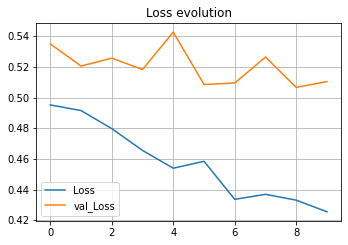

In [84]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')

Text(0.5, 1.0, 'Accuracy evolution')

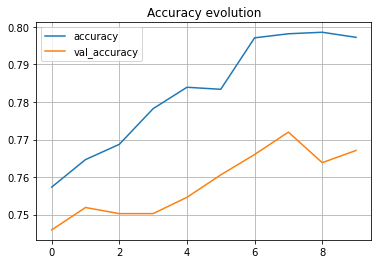

In [85]:
plt.subplot(1, 1, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy evolution')

In [109]:
   # GRU with Word2Vec embeddings and two dense layers
model = Sequential()
model.add(Embedding(embedding_matrix.shape[0],embedding_matrix.shape[1],weights=[embedding_matrix],input_length=MAX_SEQUENCE_LENGTH,trainable=False))
#model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(GRU(300,dropout=0.3)))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])   
    
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 66, 100)           2179600   
                                                                 
 bidirectional_3 (Bidirectio  (None, 600)              723600    
 nal)                                                            
                                                                 
 dense_21 (Dense)            (None, 256)               153856    
                                                                 
 dense_22 (Dense)            (None, 1)                 257       
                                                                 
Total params: 3,057,313
Trainable params: 877,713
Non-trainable params: 2,179,600
_________________________________________________________________


In [110]:
history = model.fit(X_train, y_train, epochs=10, batch_size=64,
                    validation_data=(X_test, y_test), verbose=1)

Epoch 1/10
116/116 [==============================] - 5s 23ms/step - loss: 0.6719 - accuracy: 0.6087 - val_loss: 0.6260 - val_accuracy: 0.6336
Epoch 2/10
116/116 [==============================] - 2s 16ms/step - loss: 0.6172 - accuracy: 0.6576 - val_loss: 0.6020 - val_accuracy: 0.6618
Epoch 3/10
116/116 [==============================] - 2s 17ms/step - loss: 0.5869 - accuracy: 0.6862 - val_loss: 0.5776 - val_accuracy: 0.6857
Epoch 4/10
116/116 [==============================] - 2s 16ms/step - loss: 0.5642 - accuracy: 0.7039 - val_loss: 0.5725 - val_accuracy: 0.6916
Epoch 5/10
116/116 [==============================] - 2s 16ms/step - loss: 0.5450 - accuracy: 0.7191 - val_loss: 0.5718 - val_accuracy: 0.6873
Epoch 6/10
116/116 [==============================] - 2s 16ms/step - loss: 0.5284 - accuracy: 0.7283 - val_loss: 0.5494 - val_accuracy: 0.7155
Epoch 7/10
116/116 [==============================] - 2s 16ms/step - loss: 0.5147 - accuracy: 0.7419 - val_loss: 0.5559 - val_accuracy: 0.7177

In [111]:
model.layers[0].trainable=True
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 66, 100)           2179600   
                                                                 
 bidirectional_3 (Bidirectio  (None, 600)              723600    
 nal)                                                            
                                                                 
 dense_21 (Dense)            (None, 256)               153856    
                                                                 
 dense_22 (Dense)            (None, 1)                 257       
                                                                 
Total params: 3,057,313
Trainable params: 3,057,313
Non-trainable params: 0
_________________________________________________________________


In [112]:
history = model.fit(X_train, y_train, epochs=10, batch_size=64,
                    validation_data=(X_test, y_test), verbose=1)

Epoch 1/10
116/116 [==============================] - 2s 17ms/step - loss: 0.4776 - accuracy: 0.7643 - val_loss: 0.5864 - val_accuracy: 0.7182
Epoch 2/10
116/116 [==============================] - 2s 16ms/step - loss: 0.4629 - accuracy: 0.7771 - val_loss: 0.5724 - val_accuracy: 0.7199
Epoch 3/10
116/116 [==============================] - 2s 16ms/step - loss: 0.4574 - accuracy: 0.7807 - val_loss: 0.5776 - val_accuracy: 0.7177
Epoch 4/10
116/116 [==============================] - 2s 16ms/step - loss: 0.4439 - accuracy: 0.7892 - val_loss: 0.5762 - val_accuracy: 0.7106
Epoch 5/10
116/116 [==============================] - 2s 16ms/step - loss: 0.4305 - accuracy: 0.7947 - val_loss: 0.5652 - val_accuracy: 0.7286
Epoch 6/10
116/116 [==============================] - 2s 16ms/step - loss: 0.4235 - accuracy: 0.7976 - val_loss: 0.5740 - val_accuracy: 0.7193
Epoch 7/10
116/116 [==============================] - 2s 16ms/step - loss: 0.4254 - accuracy: 0.8004 - val_loss: 0.5832 - val_accuracy: 0.7199

In [113]:

scores = model.predict(X_test)
#print(y_pred.shape)
#y_pred = np.argmax(y_pred, axis=1)
#print(y_pred.shape)

#
y_pred = [decode_sentiment(score) for score in scores]
metrics.accuracy_score(y_test, y_pred)

0.7166123778501629

In [114]:
print("classification report:")
print(metrics.classification_report(y_test, y_pred))#, target_names=target_names))

classification report:
              precision    recall  f1-score   support

           0       0.70      0.71      0.70       868
           1       0.74      0.72      0.73       974

    accuracy                           0.72      1842
   macro avg       0.72      0.72      0.72      1842
weighted avg       0.72      0.72      0.72      1842



In [115]:
print("confusion matrix: ")
print(metrics.confusion_matrix(y_test, y_pred))

confusion matrix: 
[[614 254]
 [268 706]]


Text(0.5, 1.0, 'Loss evolution')

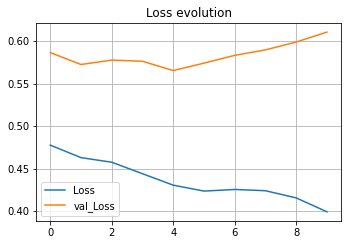

In [116]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')

Text(0.5, 1.0, 'Accuracy evolution')

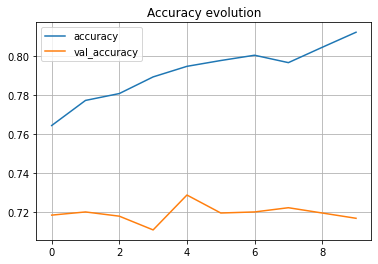

In [117]:
plt.subplot(1, 1, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy evolution')